In [266]:
import sys
import glob
import serial
import time

def serial_ports():
    '''Определение расположения последовательного порта'''
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Данная ОС не поддерживается')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result

In [267]:
rotor = ['OFF', 'V', 'mV', 'Ohm', 'Diode',
         'mA', 'A', 'Cap.', 'Hz', 'Temp.']

blue = {'V':  ['AC', 'DC', 'AC+DC'],
        'mV': ['AC', 'DC', 'AC+DC'],
        'Ohm':['Ohm', 'Low Ohm'],
        'Diode':['Diode', 'Beeper'],
        'mA':['AC', 'DC', 'AC+DC'],
        'A': ['AC', 'DC', 'AC+DC'],
        'Cap.':['Cap.'],
        'Hz':['Hz', 'Duty Factor'],
        'Temp.':['deg.C', 'deg.F']}


unit = ['None', 'V', 'mV', 'A',
        'mA', 'dB', 'dBm', 'nF',
        'uF', 'mF', 'Ohm', 'kOhm',
        'MOhm', 'GOhm', '%', 'Hz',
        'kHz', 'MHz', 'deg.C', 'deg.F',
        's', 'ms', 'ns', 'V',
        'mV', 'A', 'mA', 'Ohm',
        'kOhm', 'MOhm']


def number_and_dimension(byte_string, i):
    n = int.from_bytes(byte_string[i:i+3], byteorder='little', signed=True)
    status = '{0:b}'.format(byte_string[i+3])
    decimal_point = int(status[-3:], 2)
    try:
        unit_code = int(status[:-3], 2)
        dimension = unit[unit_code]
    except ValueError:
        dimension = unit[0]
    n = n*0.1**decimal_point
    return n, dimension

def measurement(ser):
    ser.write(bytearray([85, 85, 0, 0, 170]))
    byte_string = ser.read(19)
    rotor_code = rotor[byte_string[4]]
    blue_code = blue[rotor_code][byte_string[5]]
    range_code = byte_string[7]
    main_n, main_d = number_and_dimension(byte_string, 8)
    sub_n, sub_d = number_and_dimension(byte_string, 13)
    return blue_code, main_n, main_d, sub_n, sub_d

ser = serial.Serial(serial_ports()[0], 9600, serial.EIGHTBITS, serial.PARITY_NONE, serial.STOPBITS_ONE)
blue_code, main_n, main_d, sub_n, sub_d = measurement(ser)
print('Regime is {}.'.format(blue_code))
print('The main measurement is {:5.3f} {}. '.format(main_n, main_d))
print('The sub measurement is {:5.3f} {}.'.format(sub_n, sub_d))
ser.close()

Regime is DC.
The main measurement is -0.025 mV. 
The sub measurement is 0.000 None.


In [268]:
# Пример непрерывного измерения напряжения

def continious_measurement():
    '''Непрерывное измерение параметра с сохранением в файл'''
    ser = serial.Serial(serial_ports()[0], 9600, serial.EIGHTBITS, serial.PARITY_NONE, serial.STOPBITS_ONE)
    try:
        file_name = time.strftime("%H-%M-%S_%d-%m-%y.tsv", time.gmtime())
        with open(file_name, 'w') as f:
            while True:
                blue_code, main_n, main_d, sub_n, sub_d = measurement(ser)
                time_sec = time.time()
                line = '{0:.4f}\t{1:4.3f}\n'.format(time_sec, main_n)
                f.write(line)
    except KeyboardInterrupt:
        print('Измерение закончено. Данные записаны в файл {}'.format(file_name))
        ser.close()
        f.close()

continious_measurement()

Измерение закончено. Данные записаны в файл 17-19-13_01-01-19.tsv


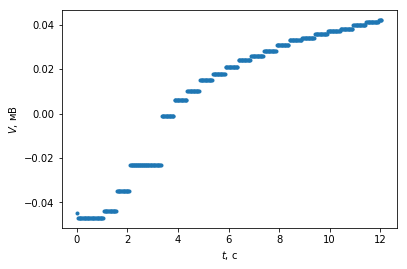

In [270]:
import matplotlib.pyplot as plt
import numpy as np

time_temperature = np.genfromtxt('17-17-39_01-01-19.tsv', delimiter='\t')

# Отсечение идентичных значений в начальный момент времени
logic_array = np.abs(time_temperature[:, 1] - time_temperature[0, 1]) > 0
time_temperature = time_temperature[np.argmax(logic_array)-1:, :]

time = time_temperature[:, 0] - time_temperature[0, 0]
temperature = time_temperature[:, 1]
plt.xlabel('$t$, c')
plt.ylabel('$V$, мВ')
plt.plot(time, temperature, '.')
plt.show()